<a href="https://colab.research.google.com/github/run-llama/llama_index/blob/main/docs/docs/examples/cookbooks/GraphRAG_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GraphRAG Implementation with LlamaIndex

[GraphRAG (Graphs + Retrieval Augmented Generation)](https://www.microsoft.com/en-us/research/project/graphrag/) combines the 

## Load Data

We will use a sample news article dataset retrieved from Diffbot, which Tomaz has conveniently made available on GitHub for easy access.

The dataset contains 2,500 samples; for ease of experimentation, we will use 50 of these samples, which include the `title` and `text` of news articles.

Prepare documents as required by LlamaIndex

In [2]:
from dotenv import load_dotenv
import os
from llama_index.llms.openai import OpenAI
from llama_index.embeddings.openai import OpenAIEmbedding
from llama_index.core import Settings
from llama_index.core import PropertyGraphIndex

import nest_asyncio
nest_asyncio.apply()

# Load the .env file

load_dotenv('../.env')

# Access the OpenAI key
openai_key = os.getenv("OPENAI_API_KEY")

llm = OpenAI(model="gpt-4o-mini", api_key=openai_key)
embed_model = OpenAIEmbedding(model="text-embedding-3-small")

Settings.llm = llm
Settings.embed_model = embed_model


In [3]:
import asyncio
import nest_asyncio

nest_asyncio.apply()
%load_ext autoreload
%autoreload 2

from typing import Any, List, Callable, Optional, Union, Dict
from IPython.display import Markdown, display

from llama_index.core.async_utils import run_jobs
from llama_index.core.indices.property_graph.utils import (
    default_parse_triplets_fn,
)
from llama_index.core.graph_stores.types import (
    EntityNode,
    KG_NODES_KEY,
    KG_RELATIONS_KEY,
    Relation,
)
from llama_index.core.llms.llm import LLM
from llama_index.core.prompts import PromptTemplate
from llama_index.core.prompts.default_prompts import (
    DEFAULT_KG_TRIPLET_EXTRACT_PROMPT,
)
from llama_index.core.schema import TransformComponent, BaseNode
from llama_index.core.bridge.pydantic import BaseModel, Field


class GraphRAGExtractor(TransformComponent):
    """Extract triples from a graph.

    Uses an LLM and a simple prompt + output parsing to extract paths (i.e. triples) and entity, relation descriptions from text.

    Args:
        llm (LLM):
            The language model to use.
        extract_prompt (Union[str, PromptTemplate]):
            The prompt to use for extracting triples.
        parse_fn (callable):
            A function to parse the output of the language model.
        num_workers (int):
            The number of workers to use for parallel processing.
        max_paths_per_chunk (int):
            The maximum number of paths to extract per chunk.
    """

    llm: LLM
    extract_prompt: PromptTemplate
    parse_fn: Callable
    num_workers: int
    max_paths_per_chunk: int

    def __init__(
        self,
        llm: Optional[LLM] = None,
        extract_prompt: Optional[Union[str, PromptTemplate]] = None,
        parse_fn: Callable = default_parse_triplets_fn,
        max_paths_per_chunk: int = 10,
        num_workers: int = 4,
    ) -> None:
        """Init params."""
        from llama_index.core import Settings

        if isinstance(extract_prompt, str):
            extract_prompt = PromptTemplate(extract_prompt)

        super().__init__(
            llm=llm or Settings.llm,
            extract_prompt=extract_prompt or DEFAULT_KG_TRIPLET_EXTRACT_PROMPT,
            parse_fn=parse_fn,
            num_workers=num_workers,
            max_paths_per_chunk=max_paths_per_chunk,
        )

    @classmethod
    def class_name(cls) -> str:
        return "GraphExtractor"

    def __call__(
        self, nodes: List[BaseNode], show_progress: bool = False, **kwargs: Any
    ) -> List[BaseNode]:
        """Extract triples from nodes."""
        return asyncio.run(
            self.acall(nodes, show_progress=show_progress, **kwargs)
        )

    async def _aextract(self, node: BaseNode) -> BaseNode:
        """Extract triples from a node."""
        assert hasattr(node, "text")

        text = node.get_content(metadata_mode="llm")
        try:
            llm_response = await self.llm.apredict(
                self.extract_prompt,
                text=text,
                max_knowledge_triplets=self.max_paths_per_chunk,
            )
            entities, entities_relationship = self.parse_fn(llm_response)
        except ValueError:
            entities = []
            entities_relationship = []

        existing_nodes = node.metadata.pop(KG_NODES_KEY, [])
        existing_relations = node.metadata.pop(KG_RELATIONS_KEY, [])
        metadata = node.metadata.copy()
        for entity, entity_type, description in entities:
            metadata[
                "entity_description"
            ] = description  # Not used in the current implementation. But will be useful in future work.
            entity_node = EntityNode(
                name=entity, label=entity_type, properties=metadata
            )
            existing_nodes.append(entity_node)

        metadata = node.metadata.copy()
        for triple in entities_relationship:
            subj, rel, obj, description = triple
            subj_node = EntityNode(name=subj, properties=metadata)
            obj_node = EntityNode(name=obj, properties=metadata)
            metadata["relationship_description"] = description
            rel_node = Relation(
                label=rel,
                source_id=subj_node.id,
                target_id=obj_node.id,
                properties=metadata,
            )

            existing_nodes.extend([subj_node, obj_node])
            existing_relations.append(rel_node)

        node.metadata[KG_NODES_KEY] = existing_nodes
        node.metadata[KG_RELATIONS_KEY] = existing_relations
        return node

    async def acall(
        self, nodes: List[BaseNode], show_progress: bool = False, **kwargs: Any
    ) -> List[BaseNode]:
        """Extract triples from nodes async."""
        jobs = []
        for node in nodes:
            jobs.append(self._aextract(node))

        return await run_jobs(
            jobs,
            workers=self.num_workers,
            show_progress=show_progress,
            desc="Extracting paths from text",
        )

In [4]:
import re
from llama_index.core.graph_stores import SimplePropertyGraphStore
import networkx as nx
from graspologic.partition import hierarchical_leiden
from llama_index.llms.openai import OpenAI
from llama_index.core.llms import ChatMessage
from graph_rag import GraphRAGStore

/Users/ngocp/Documents/projects/finance-bot/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
from llama_index.core import SimpleDirectoryReader
from llama_index.graph_stores.neo4j import Neo4jPropertyGraphStore

documents = SimpleDirectoryReader(input_files=['../data/bao-chi/gay-xuong-yte.md']).load_data()

print("length of documents:", len(documents))
print('documents:', documents[0])


from llama_index.core.node_parser import SentenceSplitter

for overlap in [5, 10, 20, 50, 100]:
    splitter = SentenceSplitter(
        chunk_size=255,
        chunk_overlap=overlap,
    )
    nodes = splitter.get_nodes_from_documents(documents)
    print(f"Chunk overlap: {overlap}, Number of nodes: {len(nodes)}")

length of documents: 1
documents: Doc ID: 4894cd65-bbfa-483d-9127-01e63cd858fa
Text: Gãy xương không bó bột có sao không? Xương có tự lành không?  Bó
bột là phương pháp điều trị quen thuộc và phổ biến nhất với chấn
thương gãy xương. Khi bị gãy ở mức độ không quá nghiêm trọng, xương
tổn thương cần được cố định đúng cách và tránh chuyển động để thúc đẩy
quá trình hồi phục. Khi đó, bác sĩ sẽ chỉ định phương pháp bó bột. Vậy
nếu gãy...
Chunk overlap: 5, Number of nodes: 10
Chunk overlap: 10, Number of nodes: 10
Chunk overlap: 20, Number of nodes: 10
Chunk overlap: 50, Number of nodes: 10
Chunk overlap: 100, Number of nodes: 13


In [6]:
KG_TRIPLET_EXTRACT_TMPL = """
-Mục tiêu-
Cho một tài liệu văn bản, xác định tất cả các thực thể và loại thực thể của chúng từ văn bản và tất cả các mối quan hệ giữa các thực thể đã xác định.
Cho văn bản, trích xuất tối đa {max_knowledge_triplets} bộ ba thực thể-quan hệ.

-Các bước-
1. Xác định tất cả các thực thể. Đối với mỗi thực thể đã xác định, trích xuất thông tin sau:
- entity_name: Tên của thực thể, viết hoa
- entity_type: Loại của thực thể
- entity_description: Mô tả toàn diện về các thuộc tính và hoạt động của thực thể
Định dạng mỗi thực thể như sau ("entity"$$$$<entity_name>$$$$<entity_type>$$$$<entity_description>)

2. Từ các thực thể đã xác định trong bước 1, xác định tất cả các cặp (source_entity, target_entity) mà *rõ ràng có liên quan* với nhau.
Đối với mỗi cặp thực thể có liên quan, trích xuất thông tin sau:
- source_entity: tên của thực thể nguồn, như đã xác định trong bước 1
- target_entity: tên của thực thể đích, như đã xác định trong bước 1
- relation: mối quan hệ giữa thực thể nguồn và thực thể đích
- relationship_description: giải thích lý do tại sao bạn nghĩ rằng thực thể nguồn và thực thể đích có liên quan với nhau

Định dạng mỗi mối quan hệ như sau ("relationship"$$$$<source_entity>$$$$<target_entity>$$$$<relation>$$$$<relationship_description>)

3. Khi hoàn thành, xuất ra.

-Dữ liệu thực tế-
######################
text: {text}
######################
output:"""

In [7]:


entity_pattern = r'\("entity"\$\$\$\$(.+?)\$\$\$\$(.+?)\$\$\$\$(.+?)\)'
relationship_pattern = r'\("relationship"\$\$\$\$(.+?)\$\$\$\$(.+?)\$\$\$\$(.+?)\$\$\$\$(.+?)\)'

def parse_fn(response_str: str) -> Any:
    entities = re.findall(entity_pattern, response_str)
    relationships = re.findall(relationship_pattern, response_str)
    print('parse_fn -----')
    print('entitis:', entities)
    # print('response_str:', response_str)
    return entities, relationships


kg_extractor = GraphRAGExtractor(
    llm=llm,
    extract_prompt=KG_TRIPLET_EXTRACT_TMPL,
    max_paths_per_chunk=2,
    parse_fn=parse_fn,
)

index = PropertyGraphIndex(
    nodes=nodes,
    property_graph_store=GraphRAGStore(),
    kg_extractors=[kg_extractor],
    show_progress=True,
)

Extracting paths from text:  15%|█▌        | 2/13 [00:04<00:21,  1.98s/it]

parse_fn -----
entitis: [('BÁC_SĨ', 'Người', 'Bác sĩ là người có chuyên môn trong lĩnh vực y tế, có khả năng chẩn đoán và điều trị các bệnh lý, bao gồm cả việc tư vấn về các phương pháp điều trị như bó bột cho bệnh nhân.'), ('BỆNH_NHÂN', 'Người', 'Bệnh nhân là người nhận sự chăm sóc y tế từ bác sĩ, có thể là người bị tổn thương xương và cần được tư vấn về việc điều trị.')]
parse_fn -----
entitis: [('BÓ BỘT', 'THỦ THUẬT Y TẾ', 'Bó bột là một phương pháp điều trị gãy xương, giúp cố định xương gãy và hỗ trợ quá trình lành xương bằng cách giữ cho xương ở vị trí đúng trong thời gian phục hồi.'), ('GÃY XƯƠNG', 'TÌNH TRẠNG Y TẾ', 'Gãy xương là tình trạng khi xương bị gãy do chấn thương hoặc áp lực, dẫn đến đau đớn và cần điều trị để hồi phục.')]


Extracting paths from text:  23%|██▎       | 3/13 [00:05<00:12,  1.28s/it]

parse_fn -----
entitis: [('VẾT GÃY', 'THỰC THỂ Y TẾ', 'Một vết gãy gọn, các đầu xương gãy vẫn thẳng hàng có nhiều khả năng lành mà không cần bó bột hơn là một vết gãy xương bị di lệch, các đầu xương gãy không còn thẳng hàng.'), ('TUỔI TÁC', 'THỰC THỂ SINH HỌC', 'Tuổi tác có thể đóng một vai trò quan trọng trong việc quyết định gãy xương không bó bột có sao không. Người trẻ tuổi có xu hướng lành vết thương nhanh hơn người lớn tuổi do xương của trẻ vẫn đang phát triển và được tưới máu tốt.')]


Extracting paths from text:  31%|███       | 4/13 [00:07<00:15,  1.69s/it]

parse_fn -----
entitis: [('BÁC_SĨ', 'Người', 'Bác sĩ là người chuyên môn trong lĩnh vực y tế, có trách nhiệm chẩn đoán và điều trị các bệnh lý, trong đó có việc điều trị gãy xương bằng cách chỉ định bó bột để cố định xương gãy và thúc đẩy quá trình lành vết thương.'), ('BÓ_BỘT', 'Vật liệu', 'Bó bột là một loại vật liệu được sử dụng để cố định xương gãy, giúp bảo vệ và hỗ trợ quá trình lành vết thương, mặc dù nó có thể gây ra nhiều khó chịu và bất tiện cho bệnh nhân.')]


Extracting paths from text:  38%|███▊      | 5/13 [00:09<00:13,  1.66s/it]

parse_fn -----
entitis: [('GÃY XƯƠNG', 'Y TẾ', 'Gãy xương là tình trạng xương bị gãy do tác động của lực, có thể xảy ra ở nhiều vị trí khác nhau trên cơ thể và cần được điều trị đúng cách để đảm bảo hồi phục. Gãy xương có thể xảy ra ở các vị trí như xương đòn, xương cổ tay, xương ngón tay, xương mắt cá chân, xương chậu và cổ xương đùi.'), ('BÓ BỘT', 'Y TẾ', 'Bó bột là phương pháp điều trị phổ biến cho các trường hợp gãy xương, giúp cố định xương gãy và hỗ trợ quá trình hồi phục. Bó bột thường được sử dụng cho những vị trí xương gãy mà cần sự ổn định để xương có thể lành lại đúng cách.')]
parse_fn -----
entitis: [('BÁC SĨ', 'Người', 'Bác sĩ là người có chuyên môn trong việc chẩn đoán và điều trị các bệnh lý, có khả năng xem xét tình trạng sức khỏe của bệnh nhân và đưa ra phương pháp điều trị phù hợp.'), ('BỆNH NHÂN', 'Người', 'Bệnh nhân là người nhận sự chăm sóc y tế, có thể là người bị chấn thương hoặc bệnh lý cần được bác sĩ thăm khám và điều trị.'), ('CHẤN THƯƠNG', 'Sự kiện', 'Chấn t

Extracting paths from text:  54%|█████▍    | 7/13 [00:09<00:05,  1.13it/s]

parse_fn -----
entitis: [('NGƯỜI TRẺ', 'Người', 'Người trẻ tuổi có xu hướng lành vết thương nhanh hơn người lớn tuổi do xương của trẻ vẫn đang phát triển và được tưới máu tốt.'), ('NGƯỜI LỚN TUỔI', 'Người', 'Người lớn tuổi có xu hướng lành vết thương chậm hơn do xương đã phát triển hoàn thiện và có thể gặp khó khăn trong việc tưới máu.'), ('GÃY XƯƠNG', 'Chấn thương', 'Gãy xương là một loại chấn thương xảy ra khi xương bị nứt hoặc gãy, có thể dẫn đến biến chứng nếu không được điều trị đúng cách.'), ('BÁC SĨ', 'Chuyên gia y tế', 'Bác sĩ là người có chuyên môn trong việc chẩn đoán và điều trị các chấn thương và bệnh tật, có thể quyết định phương pháp điều trị cho bệnh nhân.'), ('BIẾN CHỨNG', 'Tình trạng y tế', 'Biến chứng là những vấn đề phát sinh từ một chấn thương hoặc bệnh lý, có thể bao gồm nhiễm trùng hoặc các vấn đề về tưới máu.')]


Extracting paths from text:  62%|██████▏   | 8/13 [00:12<00:08,  1.61s/it]

parse_fn -----
entitis: [('XƯƠNG ĐÒN', 'THỰC THỂ XƯƠNG', 'Xương đòn là một trong những vị trí gãy xương có khả năng lành lại mà không cần bó bột, được tưới máu tốt và ít chịu áp lực.'), ('XƯƠNG CỔ TAY', 'THỰC THỂ XƯƠNG', 'Xương cổ tay là một trong những vị trí gãy xương có khả năng lành lại mà không cần bó bột, được tưới máu tốt và ít chịu áp lực.'), ('XƯƠNG NGÓN TAY', 'THỰC THỂ XƯƠNG', 'Xương ngón tay là một trong những vị trí gãy xương có khả năng lành lại mà không cần bó bột, được tưới máu tốt và ít chịu áp lực.'), ('XƯƠNG MẮT CÁ ANH', 'THỰC THỂ XƯƠNG', 'Xương mắt cá chân là một trong những vị trí gãy xương có khả năng lành lại mà không cần bó bột, được tưới máu tốt và ít chịu áp lực.'), ('XƯƠNG CHẬU', 'THỰC THỂ XƯƠNG', 'Xương chậu là một trong những vị trí gãy xương không thể bó bột được, có khả năng lành lại nhưng chịu nhiều áp lực hơn.'), ('CỔ XƯƠNG ĐÙI', 'THỰC THỂ XƯƠNG', 'Cổ xương đùi là một trong những vị trí gãy xương không thể bó bột được, có khả năng lành lại nhưng chịu nhi

Extracting paths from text:  69%|██████▉   | 9/13 [00:16<00:08,  2.17s/it]

parse_fn -----
entitis: [('GIAI ĐOẠN 2', 'GIAI ĐOẠN', 'Giai đoạn sản sinh tế bào xương mới từ nguyên xương bào, là một phần quan trọng trong quá trình lành thương xương.'), ('XƯƠNG', 'THỰC THỂ', 'Xương là một cấu trúc cứng chắc trong cơ thể, có vai trò quan trọng trong việc nâng đỡ và bảo vệ các cơ quan.'), ('BÁC SĨ', 'THỰC THỂ', 'Bác sĩ là người có chuyên môn trong lĩnh vực y tế, có trách nhiệm chẩn đoán và điều trị bệnh nhân.'), ('BÓ BỘT', 'THỰC THỂ', 'Bó bột là một phương pháp điều trị được sử dụng để cố định xương gãy, giúp thúc đẩy quá trình lành thương.')]


Extracting paths from text:  77%|███████▋  | 10/13 [00:17<00:05,  1.71s/it]

parse_fn -----
entitis: []
parse_fn -----
entitis: [('BÁC_SĨ', 'Người', 'Bác sĩ là người có chuyên môn trong lĩnh vực y tế, có khả năng chẩn đoán và điều trị các bệnh lý, bao gồm cả việc chỉ định các phương pháp điều trị cho bệnh nhân.'), ('BÓ_BỘT', 'Phương_pháp', 'Bó bột là một phương pháp điều trị không xâm lấn, thường được sử dụng để cố định xương gãy, giúp xương lành lại một cách an toàn, mặc dù có thể gây hạn chế vận động cho người bệnh.'), ('GÃY_XƯƠNG', 'Tình_trạng', 'Gãy xương là tình trạng khi xương bị gãy do chấn thương hoặc áp lực, cần được điều trị để hồi phục chức năng và sức khỏe của người bệnh.')]


Extracting paths from text:  92%|█████████▏| 12/13 [00:18<00:01,  1.34s/it]

parse_fn -----
entitis: [('BỆNH NHÂN', 'Người', 'Bệnh nhân là người nhận sự chăm sóc y tế, có thể là người bị thương hoặc mắc bệnh, và thường phải tuân thủ các hướng dẫn từ bác sĩ để phục hồi sức khỏe.'), ('TUỔI TÁC', 'Thông tin', 'Tuổi tác là một yếu tố quan trọng trong việc đánh giá tình trạng sức khỏe của bệnh nhân và quyết định phương pháp điều trị phù hợp.'), ('NGHỀ NGHIỆP', 'Thông tin', 'Nghề nghiệp của bệnh nhân có thể ảnh hưởng đến khả năng phục hồi và lựa chọn phương pháp điều trị, đặc biệt là trong các trường hợp liên quan đến hoạt động thể chất.'), ('HƯỚNG DẪN', 'Thông tin', 'Hướng dẫn là các chỉ dẫn y tế mà bệnh nhân cần tuân thủ để đảm bảo quá trình điều trị diễn ra hiệu quả.'), ('BÓ BỘT', 'Thiết bị y tế', 'Bó bột là một thiết bị y tế được sử dụng để cố định và bảo vệ các bộ phận cơ thể bị thương, giúp quá trình hồi phục diễn ra thuận lợi.'), ('NẸP', 'Thiết bị y tế', 'Nẹp là một thiết bị hỗ trợ được sử dụng để giữ cho các bộ phận cơ thể ở vị trí cố định, thường được sử dụn

Extracting paths from text: 100%|██████████| 13/13 [00:21<00:00,  1.68s/it]


parse_fn -----
entitis: [('GÃY XƯƠNG', 'Tình trạng y tế', 'Gãy xương là tình trạng tổn thương xương, xảy ra khi xương bị tác động bởi lực mạnh, dẫn đến việc xương bị gãy hoặc nứt. Tình trạng này có thể xảy ra ở nhiều mức độ nghiêm trọng khác nhau và cần được điều trị thích hợp để hồi phục.'), ('BÓ BỘT', 'Phương pháp điều trị', 'Bó bột là một phương pháp điều trị phổ biến cho các chấn thương gãy xương, nhằm cố định xương tổn thương để tránh chuyển động và thúc đẩy quá trình hồi phục. Phương pháp này không xâm lấn và được coi là an toàn.')]


Generating embeddings: 100%|██████████| 1/1 [00:02<00:00,  2.87s/it]


In [8]:
index.property_graph_store.build_communities()

/Users/ngocp/Documents/projects/finance-bot/.venv/lib/python3.10/site-packages/graspologic/partition/leiden.py:607: UserWarning: Leiden partitions do not contain all nodes from the input graph because input graph contained isolate nodes.
  warnings.warn(


Visualizing graph... BÁC SĨ
relation: GÃY XƯƠNG , ĐIỀU TRỊ , BÓ BỘT
relation: BÁC_SĨ , CHỈ_DỊNH , BÓ_BỘT
relation: BÓ_BỘT , ĐIỀU_TRỊ , GÃY_XƯƠNG
relation: BÓ BỘT , HỖ TRỢ , GÃY XƯƠNG
relation: GÃY XƯƠNG , CẦN THIẾT , BÓ BỘT
relation: GIAI ĐOẠN 2 , CÓ LIÊN QUAN , XƯƠNG
relation: BÁC SĨ , CHỈ ĐỊNH , BÓ BỘT
relation: BÓ_BỘT , GÂY_KHÓ_KHĂN , BỆNH_NHÂN
relation: GÃY XƯƠNG , CẦN , BÓ BỘT
relation: BÓ BỘT , PHƯƠNG PHÁP ĐIỀU TRỊ , GÃY XƯƠNG
relation: XƯƠNG ĐÒN , CÓ KHẢ NĂNG LÀNH LẠI , XƯƠNG CỔ TAY
relation: XƯƠNG CHẬU , KHÔNG THỂ BÓ BỘT , CỔ XƯƠNG ĐÙI
relation: VẾT GÃY , CÓ ẢNH HƯỞNG , TUỔI TÁC
relation: TUỔI TÁC , QUYẾT ĐỊNH , VẾT GÃY
relation: NGƯỜI TRẺ , SO SÁNH , NGƯỜI LỚN TUỔI
relation: GÃY XƯƠNG , ĐIỀU TRỊ , BÁC SĨ
relation: BÁC SĨ , Chăm sóc , BỆNH NHÂN
relation: BỆNH NHÂN , Bị ảnh hưởng bởi , CHẤN THƯƠNG
relation: BÁC_SĨ , TƯ_VẤN , BỆNH_NHÂN
relation: BỆNH_NHÂN , TUÂN_THỦ , BÁC_SĨ
relation: BỆNH NHÂN , Tuân thủ , HƯỚNG DẪN
relation: BỆNH NHÂN , Sử dụng , BÓ BỘT
filter_nodes_by_name:nod

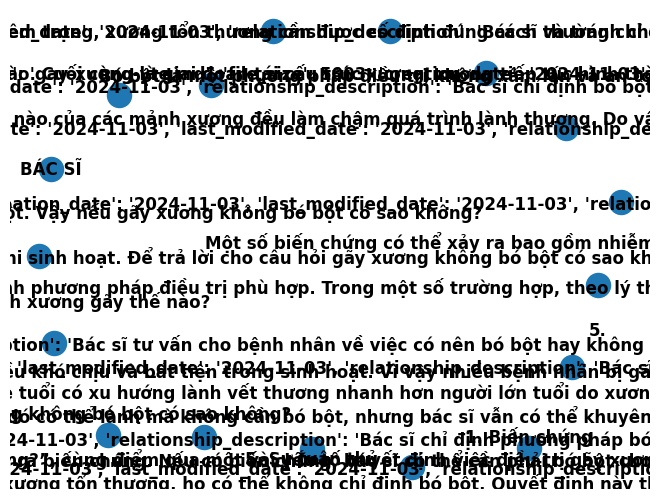

In [26]:
index.property_graph_store.visualize_graph("BÁC SĨ")

# index.property_graph_store.visualize_graph()